# HW05: Practice with algorithm selection, assessment, hyperparameter tuning, multiclass and one-class classification, and imbalanced data.

[Please put your name and NetID here.]

##### Hello Students:
 Start by downloading HW05.ipynb from this folder. Then develop it into your solution.
- Write code where you see "... your code here ..." below.
  (You are welcome to use more than one cell.)
- If you have questions, please ask them in class, office hours, or piazza. Our TA
  and I are very happy to help with the programming (provided you start early
  enough, and provided we are not helping so much that we undermine your learning).
- When you are done, run these Notebook commands:
  - Shift-L (once, so that line numbers are visible)
  - Kernel > Restart and Run All (run all cells from scratch)
  - Esc S (save)
  - File > Download as > HTML
- Turn in:
  - HW03.ipynb to Canvas's HW03.ipynb assignment
  - HW03.html to Canvas's HW03.html assignment
  - As a check, download your files from Canvas to a new 'junk' folder. Try 'Kernel > Restart
  and Run All' on the '.ipynb' file to make sure it works. Glance through the '.html' file.
- Turn in partial solutions to Canvas before the deadline. e.g. Turn in part 1,
  then parts 1 and 2, then your whole solution. That way we can award partial credit
  even if you miss the deadline. We will grade your last submission before the deadline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler

## 1. Algorithm selection for multiclass classification by optical recognition of handwritten digits

The [digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset
  has 1797 labeled images of hand-written digits.
  - $X$ = `digits.data` has shape (1797, 64).
    - Each image $\mathbf{x}_i$ is represented as the $i$th row of 64 pixel values in the 2D
      `digits.data` array that corresponds to an 8x8 photo of a handwritten digit.
  - $y$ = `digits.target` has shape (1797,). Each $y_i$ is a number from 0 to 9 indicating
    the handwritten digit that was photographed and stored in $\mathbf{x}_i$.



### 1(a) Load the digits dataset and split it into training, validation, and test sets as I did in the lecture example code [07ensemble.html](https://pages.stat.wisc.edu/~jgillett/451/burkov/07/07ensemble.html).
This step does not need to display any output.

In [2]:
digits = datasets.load_digits()
X = digits.data
y = digits.target
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size = 0.5, random_state = 0, stratify = y_tmp)

## 1(b) Use algorithm selection on training and validation data to choose a best classifier.
Loop through these four classifiers and corresponding parameters, doing a grid search
to find the best hyperparameter setting. Use only the training data for the grid search.
- SVM:
  - Try all values of `kernel` in 'linear', 'rbf'.
  - Try all values of `C` in 0.01, 1, 100.
- logistic regression:
  - Use `max_iter=5000` to avoid a nonconvergence warning.
  - Try all values of `C` in 0.01, 1, 100.
- ID3 decision tree:
  - Use `criterion='entropy` to get our ID3 tree.
  - Try all values of `max_depth` in 1, 3, 5, 7.
- kNN:
  - (Use the default Euclidean distance).
  - Try all values of `n_neighbors` in 1, 2, 3, 4.

Hint:
- Make a list of the four classifiers without setting any hyperparameters.
- Make a list of four corresponding parameter dictionaries.
- Loop through 0, 1, 2, 3:
  - Run grid search on the $i$th classifier with the $i$th parameter dictionary on the
    training data. (The grid search does its own cross-validation using the training data.)
  - Use the $i$th classifier with its best hyperparameter settings (just `clf` from
    `clf = GridSearchCV(...)`) to find the accuracy of the model on the validation data, i.e.
    find `clf.score(X_valid, y_valid)`.
- Keep track, as your loop progresses, of:
  - the index $i$ of the best classifier (initialize it to `-1` or some other value)
  - the best accuracy score on validation data (initialize it to `-np.Inf`)
  - the best classifier with its hyperparameter settings, that is the best `clf` from
    `clf = GridSearchCV(...)` (initialize it to `None` or some other value)

I needed about 30 lines of code to do this. It took a minute to run.

In [3]:
# Create arrays of models and parameters to input int GridSearchCV()
models = [svm.SVC(), linear_model.LogisticRegression(max_iter = 5000), DecisionTreeClassifier(criterion = 'entropy'), KNeighborsClassifier()]
parameters = [{'kernel':('linear', 'rbf'), 'C':[0.01, 1, 100]}, {'C':[0.01, 1, 100]}, {'max_depth':[1, 3, 5, 7]}, {'n_neighbors':[1, 2, 3, 4]}]

# Also create an array to store best accuracy scores, parameters, and models for each model
best_results = [(-np.Inf, -np.Inf, -np.Inf),(-np.Inf, -np.Inf, -np.Inf),(-np.Inf, -np.Inf, -np.Inf),(-np.Inf, -np.Inf, -np.Inf)]
model_names = ['SVM', 'Logistic Regression', 'Decision Tree', 'KNN']

# Run GridSearchCV()
for i in range(4):
    model = GridSearchCV(models[i], parameters[i]).fit(X_train, y_train)
    best_results[i] = (model_names[i], model.score(X_valid, y_valid), model.best_params_)

# Print Results
print(f"{best_results[0]}\n{best_results[1]}\n{best_results[2]}\n{best_results[3]}")

('SVM', 0.9888888888888889, {'C': 1, 'kernel': 'rbf'})
('Logistic Regression', 0.9722222222222222, {'C': 0.01})
('Decision Tree', 0.8333333333333334, {'max_depth': 7})
('KNN', 0.9888888888888889, {'n_neighbors': 3})


### 1(c) Use the test data to evaluate your already-fit best classifier and its hyperparameter settings from 1(b).
- Well, there are two tied for 'best'. Please use the first of these two.
- Report the result of calling `.score(X_test, y_test)` on your best classifier/hyperparameters.
- Show a confusion matrix from the true `y_test` values and the corresponding $\hat{y}$ values
  predicted by your best classifier/hyperparameters on `X_test`.
- For each of the wrong predictions (where `y_test` and your $\hat{y}$ values disagree), show:
  - The index $i$ in the test data of that example $\mathbf{x}$
  - The correct label $y_i$
  - Your incorrect prediction $\hat{y}_i$
  - A plot of that image (to see whether the confusion was reasonable)

Score of SVM Model: 97.8%
Confusion Matrix:
[[18  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  1  0  0]
 [ 0  0  0  0 17  0  0  0  1  0]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0]
 [ 0  1  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  1  0  0  0 17]]

Index: 61 
Correct Label: 9 
Predicted Label: 5


<Figure size 640x480 with 0 Axes>

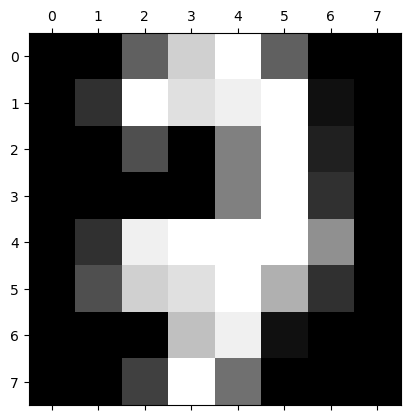


Index: 65 
Correct Label: 4 
Predicted Label: 8


<Figure size 640x480 with 0 Axes>

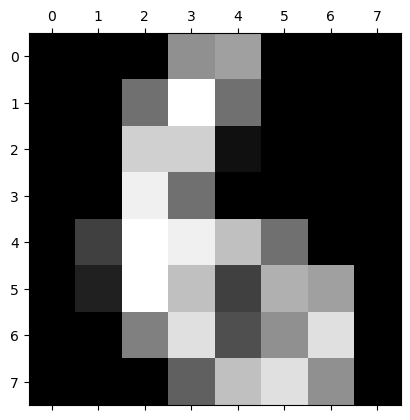


Index: 152 
Correct Label: 8 
Predicted Label: 1


<Figure size 640x480 with 0 Axes>

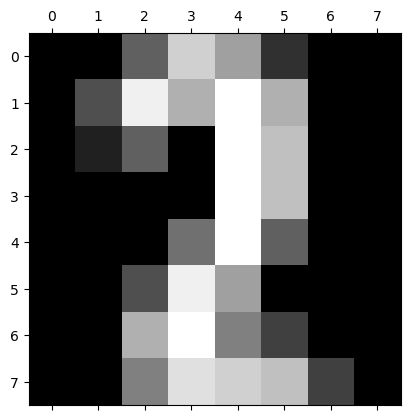


Index: 177 
Correct Label: 3 
Predicted Label: 7


<Figure size 640x480 with 0 Axes>

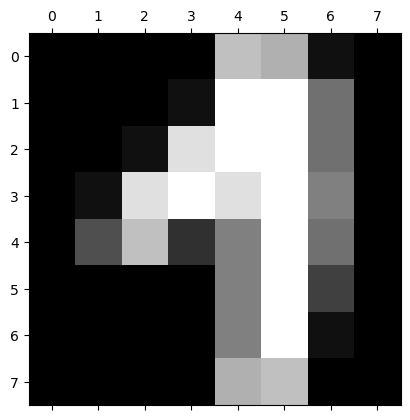

In [4]:
from sklearn import svm, linear_model, datasets
model = svm.SVC(C = best_results[0][2]['C'], kernel = best_results[0][2]['kernel']).fit(X_train, y_train)
error_indices = np.where(np.not_equal(model.predict(X_test), y_test))

print(f"Score of SVM Model: {100*model.score(X_test, y_test):.3}%")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, model.predict(X_test))}")

for index in error_indices[0]:
    print(f"\nIndex: {index} \nCorrect Label: {y_test[index]} \nPredicted Label: {model.predict(X_test)[index]}")
    plt.gray()
    plt.matshow(digits.images[index])
    plt.show()


## 2. One-class classification (outlier detection)

### 2(a) There is an old gradebook at [http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt](http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt).
Use `pd.read_table()` to read it into a DataFrame.

Hint: `pd.read_table()` has many parameters. Check its documentation to find three parameters to:
- Read from the given URL
- Use the separator '\s+', which means 'one or more whitespace characters'
- Skip the first 12 rows, as they are a note to students and not part of the gradebook

In [5]:
df = pd.read_table('http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt', sep = '\s+', skiprows = 12)

,Exam1,Exam2,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,HW6,HW7,HW8,HW9,Percentage,Rank,Percentile,percentageGrade,percentileGrade,Grade
0,121,120,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,3.5,3.0,4.0,97.13,391,99.7,A,A,A
1,119,116,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,3.5,4.0,3.5,95.22,390,99.5,A,A,A
2,125,109,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,3.0,4.0,4.0,2.5,94.90,389,99.2,A,A,A
3,117,115,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,4.0,3.5,4.0,94.27,387,98.7,A,A,A
4,110,122,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,4.0,4.0,4.0,94.27,387,98.7,A,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,94,0,4,4.0,4.0,3.64,2.4,4,4.0,4.00,...,4.0,3.0,2.5,3.0,49.09,5,1.0,F,F,F
387,0,84,4,4.0,3.7,4.00,0.0,0,4.0,4.00,...,4.0,4.0,4.0,3.0,45.91,4,0.8,F,F,F
388,0,82,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,3.5,4.0,0.0,4.0,44.75,3,0.5,F,F,F
389,84,0,4,4.0,1.0,2.12,3.2,0,0.5,1.38,...,0.0,0.0,0.0,0.0,36.21,2,0.3,F,F,F


### 2(b) Use `clf = mixture.GaussianMixture(n_components=1)` to make a one-class Gaussian model to decide which $\mathbf{x}=(\text{Exam1}, \text{Exam2})$ are outliers:

- Set a matrix X to the first two columns, Exam1 and Exam.
- These exams were worth 125 points each. Transform scores to percentages in $[0, 100]$.

  Hint: I tried the MinMaxScaler() first, but it does the wrong thing if there aren't scores
  of 0 and 125 in each column. So, instead, I just multiplied the whole matrix by 100 / 125.
- Fit your classifier to X.
  
  Hint:
  - The reference page for `mixture.GaussianMixture` includes a `fit(X, y=None)` method
    with the comment that y is ignored (as this is an unsupervised learning algorithm--there
    is no $y$) but present for API consistency. So we can fit with just X.
  - I got a warning about "KMeans ... memory leak". You may ignore this
    warning if you see it. I still got satisfactory results.
- Print the center $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$ from the two-variable
  $N_2(\mathbf{\mu}, \mathbf{\Sigma})$ distribution you estimated.

In [6]:
X = 100*df[['Exam1', 'Exam2']]/125
clf = mixture.GaussianMixture(n_components = 1).fit(X)
print(f"Center: {clf.means_[0]} \nCovariances Matrix: {clf.covariances_[0]}")

Center: [82.81329923 71.01176471] 
Covariancen Matrix: [[155.51123078  73.02961336]
 [ 73.02961336 180.87014392]]


### 2(c) Here I have given you code to make a contour plot of the negative log likelihood $-\ln f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ for $\mathbf{X} \sim N_2(\mathbf{\mu}, \mathbf{\Sigma})$, provided you have set `clf`.

```
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')
```

Paste my code into your code cell below and add more code:
- Add black $x$- and $y$- axes. Label them Exam1 and Exam2.
- Plot the data points in blue.
- Plot $\mathbf{\mu}=$ `clf.means_` as a big lime dot.
- Overplot (i.e. plot again) in red the 8 outliers determined by a threshold consisting
  of the 0.02 quantile of the pdf values $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$
  for each $\mathbf{x}$ in X.
  
  Hint: `clf.score_samples(X)` gives log likelihood, so `np.exp(clf.score_samples(X))`
  gives the required $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ values.

/Users/anaiscoronaperez/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


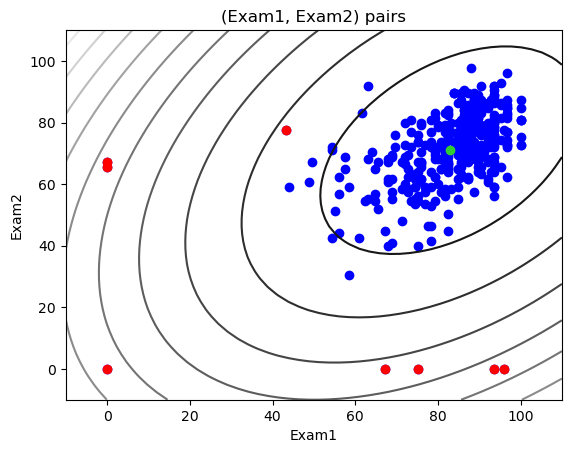

In [7]:
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')

# Label axis and plot data points
plt.xlabel('Exam1')
plt.ylabel('Exam2')
plt.scatter(X['Exam1'], X['Exam2'], color = 'blue')
plt.scatter(clf.means_[0][0], clf.means_[0][1], color = 'limegreen')

# Plot outliers
f = np.exp(clf.score_samples(X)) # obtain f values
outliers = f[f < np.quantile(np.exp(clf.score_samples(X)), 0.02)] # get f values within quantile

for index in range(len(f)):
    if f[index] in outliers:
        plt.scatter(X['Exam1'][index], X['Exam2'][index], color = 'red')
        

### What characterizes 7 of these 8 outliers? Write your answer in a markdown cell.

For 7 outliers, they either have Exam1 equal zero with Exam2 being a nonzero score or they had Exam2 equal zero with Exam1 being a nonzero score.

### 2(d) Write a little code to report whether, by the 0.02 quantile criterion, $\mathbf{x}=$ (Exam1=50, Exam2=100) is an outlier.

Hint: Compare $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ to your threshold

In [15]:
x = [[50, 100]]
quantile = np.quantile(np.exp(clf.score_samples(X)), 0.02)
print(f"Since the score for x = (Exam1 = 50, Exam2 = 100): {clf.score(x):.3} is less than {quantile}, it is an outlier")

Since the score for x = (Exam1 = 50, Exam2 = 100): -17.0 is less than 5.92977853432971e-06, it is an outlier


/Users/anaiscoronaperez/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


## 3. Explore the fact that accuracy can be misleading for imbalanced data.
Here I make a fake imbalanced data set by randomly sampling $y$ from a distribution with $P(y = 0) = 0.980$ and $P(y = 1) = 0.020$.

In [16]:
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, weights=[0.980, 0.020],
                           n_clusters_per_class=1, flip_y=0.01, random_state=0)
print(f'np.bincount(y)={np.bincount(y)}; we expect about 980 zeros and 20 ones.')
print(f'np.mean(y)={np.mean(y)}; we expect the proportion of ones to be about 0.020.')

np.bincount(y)=[973  27]; we expect about 980 zeros and 20 ones.
np.mean(y)=0.027; we expect the proportion of ones to be about 0.020.


Here I split the data into 50% training and 50% testing data.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0, stratify=y)
print(f'np.bincount(y_train)={np.bincount(y_train)}')
print(f'np.mean(y_train)={np.mean(y_train)}.')
print(f'np.bincount(y_test)={np.bincount(y_test)}.')
print(f'np.mean(y_test)={np.mean(y_test)}.')

np.bincount(y_train)=[486  14]
np.mean(y_train)=0.028.
np.bincount(y_test)=[487  13].
np.mean(y_test)=0.026.


### 3a. Train and assess a gradient boosting model.
- Train on the training data.
- Use 100 trees of maximum depth 1 and learning rate $\alpha = 0.25$.
- Use `random_state=0` (to give us all a chance of getting the same results).
- Display the accuracy, precision, recall, and AUC on the test data. Use 3 decimal places.
  Use a labeled print statement with 3 decimal places so the reader can easily find each metric.
- Make an ROC curve from your classifier and the test data.

Accuracy is: 0.982
Precision is: 0.7
Recall is: 0.538
AUC is: 0.769


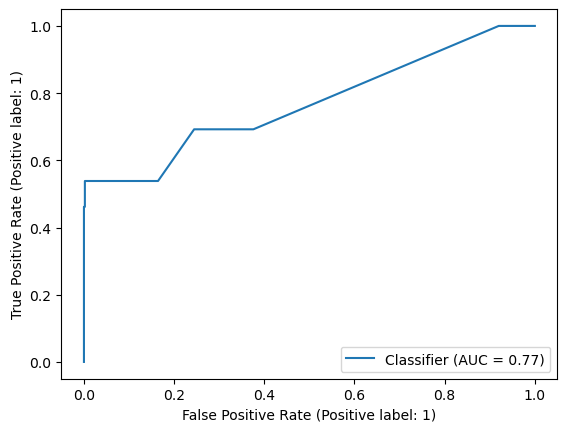

In [29]:
# Train and asses model
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25, max_depth=1, random_state=0).fit(X_train, y_train)
print(f"Accuracy is: {accuracy_score(y_true = y_test, y_pred = clf.predict(X_test))}")
print(f"Precision is: {precision_score(y_true = y_test, y_pred = clf.predict(X_test))}")
print(f"Recall is: {recall_score(y_true = y_test, y_pred = clf.predict(X_test)):.3}")
print(f"AUC is: {roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]):.3}")

# Show curve
RocCurveDisplay.from_predictions(y_true = y_test, y_pred = clf.predict_proba(X_test)[:, 1])
plt.show(block=False)


Note the high accuracy but lousy precision, recall, and AUC.

Note that since the data have about 98% $y = 0$, we could get about 98% accuracy
by just always predicting $\hat{y} = 0$. High accuracy alone is not necessarily helpful.

### 3b. Now oversample the data to get a balanced data set.
- Use the `RandomOverSampler(random_state=0)` to oversample and get a balanced data set.
- Repeat my `train_test_split()` block from above.
- Repeat your train/assess block from above.

Accuracy is: 0.9568345323741008
Precision is: 0.9703389830508474
Recall is: 0.942
AUC is: 0.993


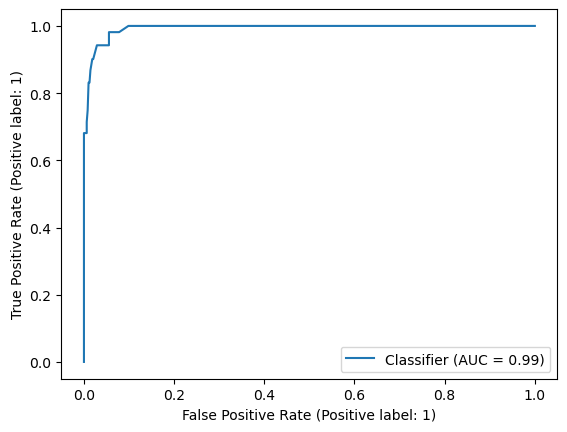

In [30]:
# Oversample data and split
X, y = RandomOverSampler(random_state = 0).fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0, stratify=y)

# Train and asses GradientBoosting model
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25, max_depth=1, random_state=0).fit(X_train, y_train)
print(f"Accuracy is: {accuracy_score(y_true = y_test, y_pred = clf.predict(X_test))}")
print(f"Precision is: {precision_score(y_true = y_test, y_pred = clf.predict(X_test))}")
print(f"Recall is: {recall_score(y_true = y_test, y_pred = clf.predict(X_test)):.3}")
print(f"AUC is: {roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]):.3}")

# Display curve
RocCurveDisplay.from_predictions(y_true = y_test, y_pred = clf.predict_proba(X_test)[:, 1])
plt.show(block=False)


Note that we traded a little accuracy for much improved precision, recall, and AUC.

If you do classification in your project and report accuracy, please
also report the proportions of $y = 0$ and $y = 1$ in your test data so that
we get insight into whether your model improves upon always guessing $\hat{y} = 0$
or always guessing $\hat{y} = 1$.